## 01-BIBLIOTECAS

In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from io import StringIO
import requests
from sklearn.pipeline import Pipeline
from joblib import dump
import sklearn
from io import StringIO
from io import BytesIO
from joblib import load
import xgboost as xgb

In [48]:
pip install --upgrade pandas numpy scikit-learn requests

In [13]:
pip install shap

In [14]:
import shap

##02-CARGA DE PREPROCESADOR Y MODELO.
Lo tenemos que hacer de esta forma, porque usando .joblib, se cargan dañados.

In [49]:
# Función para filtrar columnas
def filtrar_columnas(df):
    columnas_a_mantener = [
        'International plan', 'Voice mail plan', 'Number vmail messages',
        'Total day minutes', 'Total day charge', 'Total eve minutes',
        'Total eve charge', 'Total night minutes', 'Total night charge',
        'Total intl minutes', 'Total intl calls'                   # Como se puede observar, en el prepro, NO se incluye el target
    ]
    return df[columnas_a_mantener]

# Función que transforma 'International plan' a int.
def mapear_international_plan(df):
    df_copy = df.copy()  # Crear una copia del DataFrame
    df_copy['International plan'] = df_copy['International plan'].map({'Yes': 1, 'No': 0})
    return df_copy

# Función que transforma 'Voice mail plan' a int.
def mapear_voice_mail_plan(df):
    df_copy = df.copy()  # Crear una copia del DataFrame
    df_copy['Voice mail plan'] = df_copy['Voice mail plan'].map({'Yes': 1, 'No': 0})
    return df_copy

# Función para eliminar outliers
def eliminar_outliers(df):
    columns_to_check = ['Number vmail messages', 'Total day minutes',
                             'Total day charge', 'Total eve minutes',
                             'Total eve charge', 'Total night minutes',
                             'Total night charge', 'Total intl minutes',
                             'Total intl calls']

    df_copy = df.copy()

    for column in columns_to_check:
        q1 = df_copy[column].quantile(0.25)
        q3 = df_copy[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Eliminar las filas con outliers solo en la columna actual
        df_copy = df_copy.drop(df_copy[(df_copy[column] < lower_bound) | (df_copy[column] > upper_bound)].index)

    return df_copy





# Creación de transformadores
Best_caracter = FunctionTransformer(filtrar_columnas)
Mapeo_01 = FunctionTransformer(mapear_international_plan)
Mapeo_02 = FunctionTransformer(mapear_voice_mail_plan)
Outliers_drop = FunctionTransformer(eliminar_outliers)


# Creación del pipeline de preprocesamiento
Prepro01 = Pipeline(steps=[
    ("Best_features", Best_caracter),
    ("Mapeo_01", Mapeo_01),
    ("Mapeo_02", Mapeo_02),
    ("Outliers_drop", Outliers_drop),
])
Prepro01

Pipeline(steps=[('Best_features',
                 FunctionTransformer(func=<function filtrar_columnas at 0x7f43eade2680>)),
                ('Mapeo_01',
                 FunctionTransformer(func=<function mapear_international_plan at 0x7f43eade2b00>)),
                ('Mapeo_02',
                 FunctionTransformer(func=<function mapear_voice_mail_plan at 0x7f43eade2f80>)),
                ('Outliers_drop',
                 FunctionTransformer(func=<function eliminar_outliers at 0x7f43eade1b40>))])

In [50]:
# Función para filtrar columnas
def filtrar_columnas(df):
    columnas_a_mantener = [
        'International plan', 'Voice mail plan', 'Number vmail messages',
        'Total day minutes', 'Total day charge', 'Total eve minutes',
        'Total eve charge', 'Total night minutes', 'Total night charge',
        'Total intl minutes', 'Total intl calls', 'Churn'                  # Como se puede observar, en el prepro, NO se incluye el target
    ]
    return df[columnas_a_mantener]

# Función que transforma 'International plan' a int.
def mapear_international_plan(df):
    df_copy = df.copy()  # Crear una copia del DataFrame
    df_copy['International plan'] = df_copy['International plan'].map({'Yes': 1, 'No': 0})
    return df_copy

# Función que transforma 'Voice mail plan' a int.
def mapear_voice_mail_plan(df):
    df_copy = df.copy()  # Crear una copia del DataFrame
    df_copy['Voice mail plan'] = df_copy['Voice mail plan'].map({'Yes': 1, 'No': 0})
    return df_copy

# Función para eliminar outliers
def eliminar_outliers(df):
    columns_to_check = ['Number vmail messages', 'Total day minutes',
                             'Total day charge', 'Total eve minutes',
                             'Total eve charge', 'Total night minutes',
                             'Total night charge', 'Total intl minutes',
                             'Total intl calls']

    df_copy = df.copy()

    for column in columns_to_check:
        q1 = df_copy[column].quantile(0.25)
        q3 = df_copy[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Eliminar las filas con outliers solo en la columna actual
        df_copy = df_copy.drop(df_copy[(df_copy[column] < lower_bound) | (df_copy[column] > upper_bound)].index)

    return df_copy



# Definir función de mapeo de la variable objetivo
def mapear_target(df):
    df_copy = df.copy()  # Crear una copia del DataFrame
    df_copy['Churn'] = df_copy['Churn'].astype(int)  # Convertir valores booleanos a enteros (0 para False, 1 para True)
    return df_copy

# Df virgen
file_id = "16ypxCIBr9wSGVEaXqWdZUfz9w4xzccwo"
download_link = f"https://drive.google.com/uc?id={file_id}"
response = requests.get(download_link)
csv_data = StringIO(response.text)
df = pd.read_csv(csv_data, encoding='utf-8')

#Aplicamos funciones
df1 = filtrar_columnas(df)
df1 = mapear_international_plan(df1)
df1 = mapear_voice_mail_plan(df1)
df1 = eliminar_outliers(df1)
df1 = mapear_target(df1)


# Definimos las características según lo ya definido en la etapa de elección de modelo (no incluido en el Prepro01).
X = df1[['International plan', 'Voice mail plan', 'Number vmail messages',
        'Total day minutes', 'Total day charge', 'Total eve minutes',
        'Total eve charge', 'Total night minutes', 'Total night charge',
        'Total intl minutes', 'Total intl calls']]
y = df1.Churn

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Entrenar el modelo XGBoost
modelo = RandomForestClassifier()
modelo.fit(X_train, y_train)

RandomForestClassifier()

In [51]:
# IMPORTAMOS SET VIRGEN
file_id = "16ypxCIBr9wSGVEaXqWdZUfz9w4xzccwo"
download_link = f"https://drive.google.com/uc?id={file_id}"
response = requests.get(download_link)
csv_data = StringIO(response.text)
df = pd.read_csv(csv_data, encoding='utf-8')

In [52]:
X = df[['International plan', 'Voice mail plan', 'Number vmail messages',
        'Total day minutes', 'Total day charge', 'Total eve minutes',
        'Total eve charge', 'Total night minutes', 'Total night charge',
        'Total intl minutes', 'Total intl calls']]
y = df.Churn

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [53]:
X_test=Prepro01.fit_transform(X_test)
X_train=Prepro01.fit_transform(X_train)

In [54]:
dd=modelo.predict(X_test)
dd

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## 03-SHAP

In [39]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2002 entries, 1855 to 860
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   International plan     2002 non-null   int64  
 1   Voice mail plan        2002 non-null   int64  
 2   Number vmail messages  2002 non-null   int64  
 3   Total day minutes      2002 non-null   float64
 4   Total day charge       2002 non-null   float64
 5   Total eve minutes      2002 non-null   float64
 6   Total eve charge       2002 non-null   float64
 7   Total night minutes    2002 non-null   float64
 8   Total night charge     2002 non-null   float64
 9   Total intl minutes     2002 non-null   float64
 10  Total intl calls       2002 non-null   int64  
dtypes: float64(7), int64(4)
memory usage: 187.7 KB


In [16]:
X_train

,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day charge,Total eve minutes,Total eve charge,Total night minutes,Total night charge,Total intl minutes,Total intl calls
1855,0,0,0.0,0.426564,0.426623,0.505755,0.505713,0.622305,0.622314,0.591549,0.555556
2244,0,0,0.0,0.175685,0.175692,0.550000,0.550148,0.504089,0.504132,0.542254,0.555556
2525,0,0,0.0,0.352776,0.352832,0.346403,0.346593,0.557621,0.557851,0.507042,0.111111
961,0,0,0.0,0.339424,0.339396,0.505036,0.505290,0.484015,0.484298,0.669014,0.444444
1618,0,0,0.0,0.377020,0.377015,0.529496,0.529412,0.976952,0.976860,0.809859,0.111111
...,...,...,...,...,...,...,...,...,...,...,...
1638,0,0,0.0,0.624034,0.624018,0.649281,0.649175,0.795911,0.795868,0.633803,0.888889
1095,0,0,0.0,0.274069,0.274080,0.237050,0.236987,0.155390,0.155372,0.436620,0.555556
1130,0,0,0.0,0.581518,0.581439,0.625540,0.625476,0.591822,0.591736,0.845070,0.555556
1294,0,0,0.0,0.664793,0.664737,0.502518,0.502751,0.239777,0.239669,0.711268,0.444444


In [55]:
# Crear el objeto explainer de SHAP
explainer = shap.Explainer(modelo,X_train)

In [41]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 472 entries, 1915 to 1992
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   International plan     472 non-null    int64  
 1   Voice mail plan        472 non-null    int64  
 2   Number vmail messages  472 non-null    int64  
 3   Total day minutes      472 non-null    float64
 4   Total day charge       472 non-null    float64
 5   Total eve minutes      472 non-null    float64
 6   Total eve charge       472 non-null    float64
 7   Total night minutes    472 non-null    float64
 8   Total night charge     472 non-null    float64
 9   Total intl minutes     472 non-null    float64
 10  Total intl calls       472 non-null    int64  
dtypes: float64(7), int64(4)
memory usage: 44.2 KB


In [56]:
shap_values = explainer(X_test)

100%|===================| 942/944 [00:15<00:00]       

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.939700, while the model output was 0.960000. If this difference is acceptable you can set check_additivity=False to disable this check.

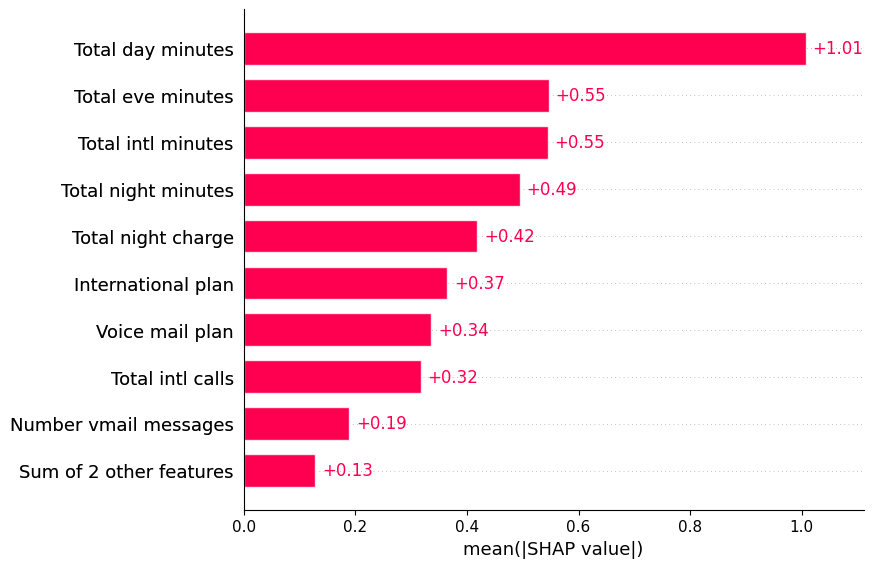

In [57]:
shap.plots.bar(shap_values)

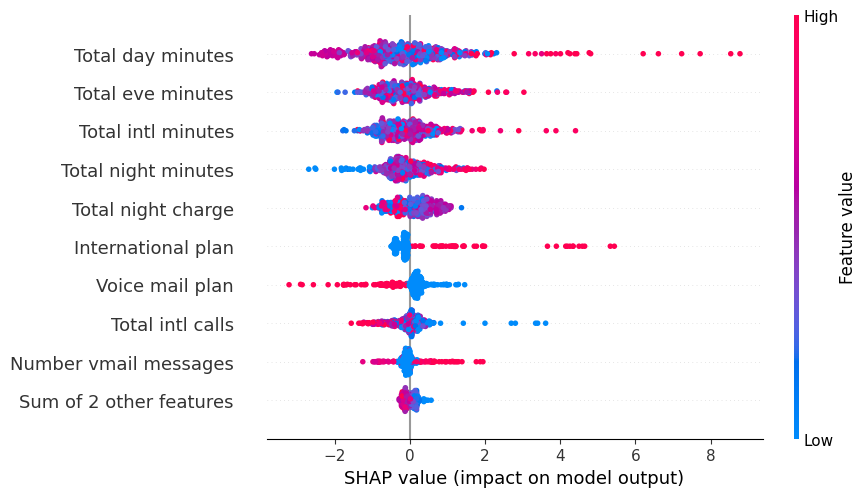

In [58]:
shap.plots.beeswarm(shap_values)

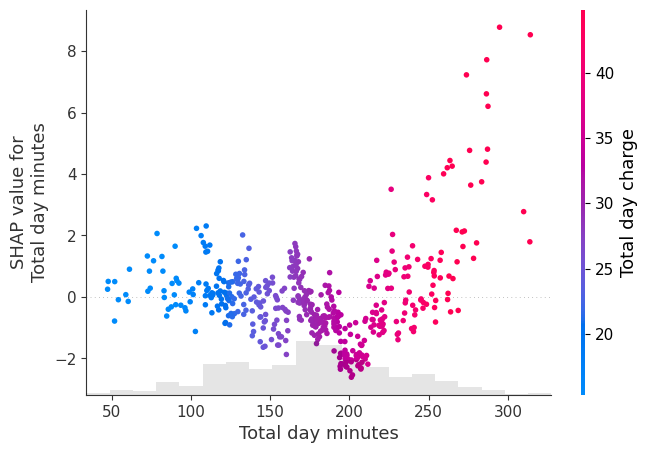

In [59]:
shap.plots.scatter(shap_values[:,"Total day minutes"],color=shap_values)

In [66]:
shap.initjs()
shap.plots.force(shap_values[0],figsize=(15,3),link='logit')

## 04-CONCL